In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

%matplotlib inline

In [2]:
mat = loadmat('data/example1kinect.mat')

In [4]:
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'amplitudes1', 'distances1', 'cloud1'])


In [5]:
A = mat['amplitudes1']  
D = mat['distances1'] 
PC = mat['cloud1']    

In [6]:
A.shape

(424, 512)

In [7]:
D.shape

(424, 512)

In [8]:
PC.shape

(424, 512, 3)

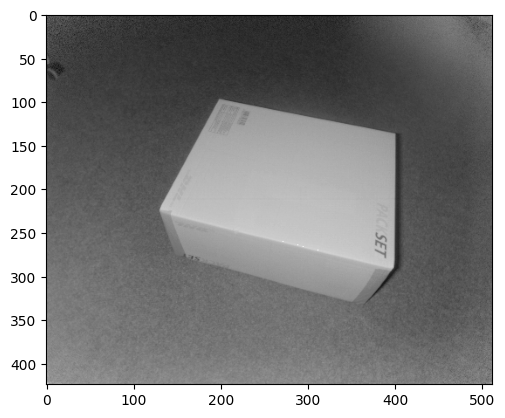

In [9]:
plt.imshow(A, norm='log', cmap='gray')

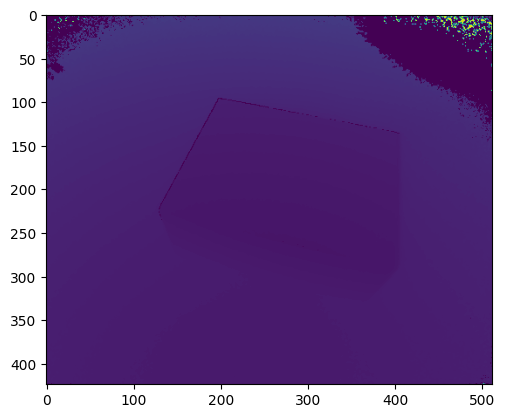

In [10]:
plt.imshow(D, norm='linear')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0650511980056763..1.8000001907348633].


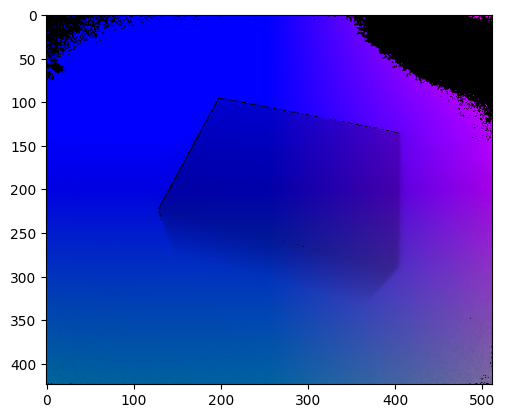

In [11]:
plt.imshow(PC)

In [12]:
x = PC[:, :, 0]
y = PC[:, :, 1]
z = PC[:, :, 2]

In [13]:
x.shape

(424, 512)

In [14]:
x_flat = x.ravel() 
y_flat = y.ravel()
z_flat = z.ravel()

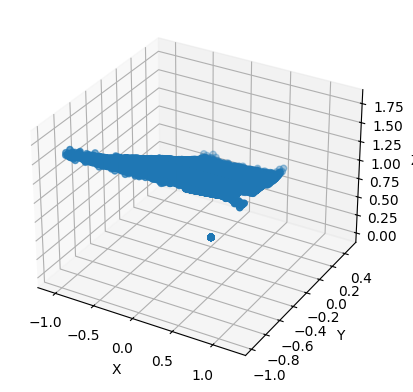

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x_flat, ys=y_flat, zs=z_flat)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [43]:
subsample_percentage = 1

In [44]:
n = len(x_flat)
subsample_size = int(n * (subsample_percentage / 100))
indices = np.random.choice(n, subsample_size, replace=False)

In [45]:
x_sub = x_flat[indices]
y_sub = y_flat[indices]
z_sub = z_flat[indices]

In [46]:
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x_sub, ys=y_sub, zs=z_sub)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [47]:
subsample_size = 3
point_cloud = PC
height, width, _ =point_cloud.shape
row_indices = np.random.choice(height, subsample_size, replace=False)
col_indices = np.random.choice(width, subsample_size, replace=False)
points_sub = point_cloud[row_indices, col_indices, :]

In [48]:
points_sub

array([[-0.41733605,  0.34142196,  0.64700007],
       [ 0.09884885,  0.15020515,  0.63200009],
       [ 0.56760305, -0.06752677,  0.94500005]])

https://kitchingroup.cheme.cmu.edu/blog/2015/01/18/Equation-of-a-plane-through-three-points/

In [49]:
def dist(x, y, z, a, b, c, d):
    nominator = abs(a*x + b*y + c*z -d)
    denominator = math.sqrt(a**2 + b**2 + c**2)
    return nominator/denominator

In [50]:
def ransac_plane(point_cloud, threshold, max_iter):
    best_score = 0
    best_inliers = []
    for _ in range(max_iter):
        cnt = 0
        subsample_size = 3
        height, width, _ = point_cloud.shape
        row_indices = np.random.choice(height, subsample_size, replace=False)
        col_indices = np.random.choice(width, subsample_size, replace=False)
        points_sub = point_cloud[row_indices, col_indices, :]
        a = points_sub[2] - points_sub[0]
        b = points_sub[2] - points_sub[1]
        normal_vector = np.cross(a, b)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        a, b, c = normal_vector
        d = np.dot(normal_vector, points_sub[0])
        if d < 1e-6:  # Small threshold to avoid division by zero
            print("skipped")
            continue
        inliers = []
        for row in range(height):
            for column in range(width):
                x, y, z =  point_cloud[row, column, :]
                if x == 0 and y == 0 and z == 0:
                    pass
                else:
                    cnt += 1
                    result = dist(x, y, z, a, b, c, d)
                    if abs(result) < threshold:
                        inliers.append((row, column))
        print("count: ", cnt)
        print("all: ", len(inliers))
        score = len(inliers) / cnt *100
        print(f"percentage of inliers are {score}.")
        if score > best_score:
            best_score = score
            best_inliers = inliers
    print("best score: ", best_score)
    return best_inliers, d

In [51]:
best_inliers, d_floor = ransac_plane(PC, 0.1, 10)

skipped
count:  202007
all:  137150
percentage of inliers are 67.8936868524358.
skipped
skipped
count:  202007
all:  159039
percentage of inliers are 78.7294499695555.
skipped
count:  202007
all:  127491
percentage of inliers are 63.112169380269.
count:  202007
all:  85077
percentage of inliers are 42.11586727192622.
skipped
count:  202007
all:  104660
percentage of inliers are 51.81008578910632.
best score:  78.7294499695555


In [55]:
visualize_plane(PC, best_inliers, a, b, c, d)

NameError: name 'a' is not defined

In [52]:
import numpy as np
from sklearn.linear_model import RANSACRegressor

# Assuming your point_cloud and inliers are defined

def sklearn_ransac_plane(point_cloud):
    # Flatten the point cloud
    x_vals = point_cloud[:, :, 0].flatten()
    y_vals = point_cloud[:, :, 1].flatten()
    z_vals = point_cloud[:, :, 2].flatten()

    # Filter out invalid points (where z=0)
    valid_mask = (z_vals != 0)
    X = np.column_stack((x_vals[valid_mask], y_vals[valid_mask]))  # X and Y as features
    Z = z_vals[valid_mask]  # Z as the target

    # Fit the RANSAC regressor
    ransac = RANSACRegressor()
    ransac.fit(X, Z)

    # Extract the coefficients (a, b) and intercept (d) of the plane z = ax + by + d
    a, b = ransac.estimator_.coef_
    d = ransac.estimator_.intercept_

    print(f"Sklearn RANSAC Plane: z = {a}x + {b}y + {d}")
    
    # Get the inlier mask
    inlier_mask = ransac.inlier_mask_

    return inlier_mask, (a, b, d)

# Use this function to get the inliers and plane equation from sklearn RANSAC
sklearn_inliers, (a_sklearn, b_sklearn, d_sklearn) = sklearn_ransac_plane(point_cloud)

# You can visualize the sklearn inliers like you did with your own RANSAC
# For comparison, you can also visualize both planes and compare the inliers


Sklearn RANSAC Plane: z = 0.018190853668597143x + -0.7239813765984959y + 0.8933809153917022


In [33]:
def get_inlier_coordinates(inlier_mask, point_cloud_shape):
    height, width, _ = point_cloud_shape.shape
    
    # Find the indices of True values in the 1D inlier mask
    inlier_indices = np.where(inlier_mask)[0]  # 1D indices where inlier_mask is True
    
    # Convert the 1D indices back to 2D indices in the (height, width) grid
    row_indices, col_indices = np.unravel_index(inlier_indices, (height, width))
    
    # Combine row and column indices into a list of (x, y) tuples
    inlier_coordinates = [(int(row), int(col)) for row, col in zip(row_indices, col_indices)]
    
    return inlier_coordinates


In [34]:
inlier_points = np.array([PC[row, col, :] for row, col in best_inliers])

In [35]:
[

In [36]:
sklearn_inliers.shape

(202007,)

In [37]:
# Call the sklearn RANSAC function to get inliers and plane coefficients
sklearn_inliers, (a_sklearn, b_sklearn, d_sklearn) = sklearn_ransac_plane(point_cloud)
sk_inliers = get_inlier_coordinates(sklearn_inliers, PC)
sk_inliers = np.array([PC[row, col, :] for row, col in sk_inliers])
# Visualize the sklearn RANSAC results
visualize_plane(PC, sk_inliers, a_sklearn, b_sklearn, -1, d_sklearn)  # Use c=-1 (standard plane)


Sklearn RANSAC Plane: z = 0.01287223763253251x + -0.7134534782963596y + 0.8918332908406296


ValueError: too many values to unpack (expected 2)

In [38]:
%matplotlib qt
visualize_plane(PC, best_inliers, a, b, c, d)

NameError: name 'a' is not defined

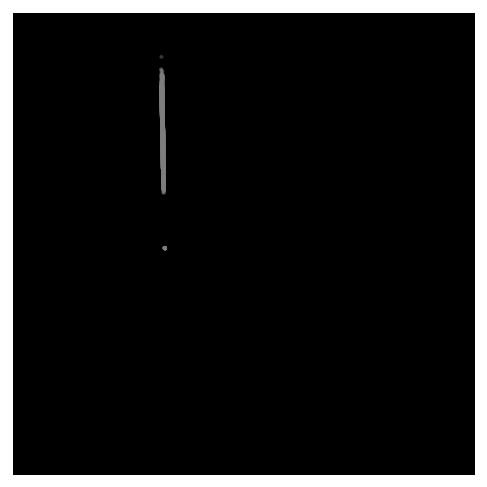

In [39]:
def visualize_2d_floor_mask(point_cloud, best_inliers):
    # Get the dimensions of the point cloud (height and width)
    height, width, _ = point_cloud.shape

    # Create a mask initialized to zeros
    floor_mask = np.zeros((height, width), dtype=np.uint8)

    # Set the inliers in the mask to 1
    for row, col in best_inliers:
        floor_mask[row, col] = 1

    # Visualize the mask using imshow
    plt.imshow(floor_mask, cmap='gray')
    plt.axis('off')
    plt.savefig('floor_mask.png', bbox_inches='tight', pad_inches=0)
    plt.show()

%matplotlib inline
# Call this after running RANSAC to visualize the floor mask
visualize_2d_floor_mask(point_cloud, best_inliers)

In [40]:
img = cv2.imread('floor_mask.png', cv2.IMREAD_GRAYSCALE)
kernel = np.ones((5,5),np.uint8)

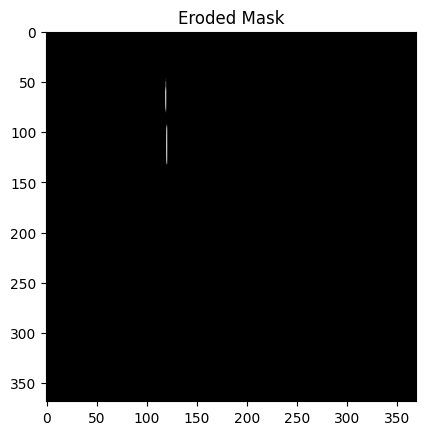

In [41]:
eroded_img = cv2.erode(img, kernel, iterations=1)

# Visualize the eroded image
plt.imshow(eroded_img, cmap='gray')
plt.title('Eroded Mask')
plt.show()

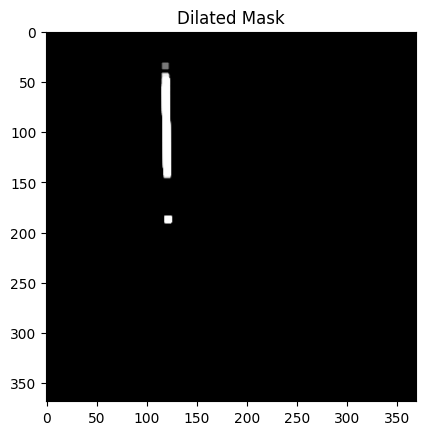

In [42]:
dilated_img = cv2.dilate(img, kernel, iterations=1)

# Visualize the eroded image
plt.imshow(dilated_img, cmap='gray')
plt.title('Dilated Mask')
plt.show()

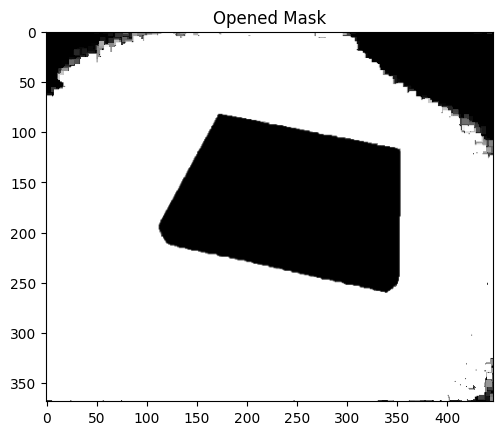

In [135]:
opened_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# Visualize the eroded image
plt.imshow(opened_img, cmap='gray')
plt.title('Opened Mask')
plt.show()

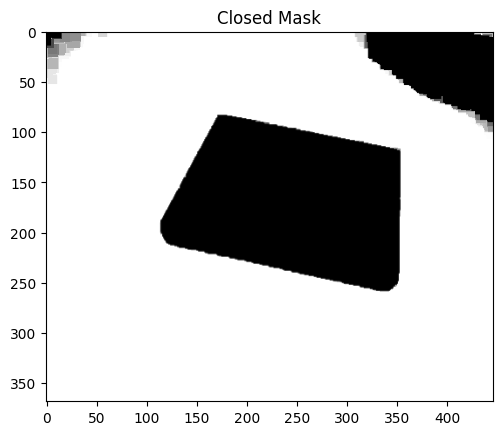

In [136]:
closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)

# Visualize the eroded image
plt.imshow(closed_img, cmap='gray')
plt.title('Closed Mask')
plt.show()

In [137]:
inlier_coords = np.array(best_inliers)


In [138]:
inlier_coords

array([[  0,  18],
       [  0,  19],
       [  0,  20],
       ...,
       [423, 508],
       [423, 509],
       [423, 510]])

In [139]:
PC.shape

(424, 512, 3)

In [140]:
# Zero out the inliers in the point cloud
for coord in inlier_coords:
    PC[coord[0], coord[1]] = [0, 0, 0]

In [141]:
box_inliers, d_box = ransac_plane(PC, 0.4, 100)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_28808\2683965986.py:14: RuntimeWarning: invalid value encountered in divide
  normal_vector = normal_vector / np.linalg.norm(normal_vector)


count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
skipped
count:  39977
all:  0
percentage of inliers are 0.0.
skipped
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percentage of inliers are 0.0.
count:  39977
all:  0
percenta

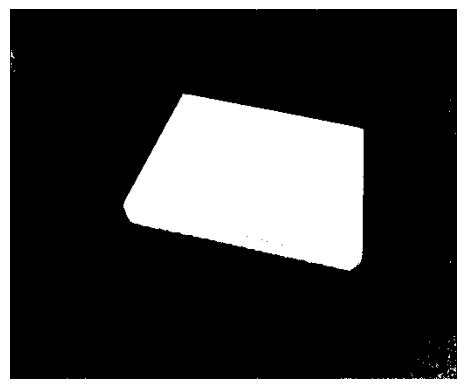

In [142]:
visualize_2d_floor_mask(PC, box_inliers)

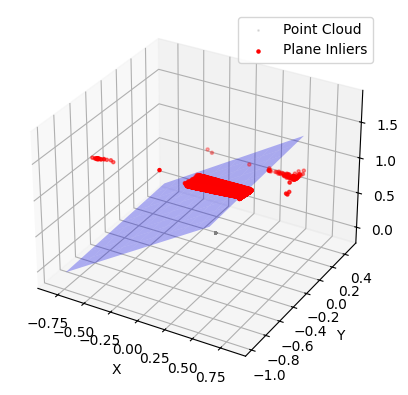

In [143]:
visualize_plane(PC,box_inliers, a, b, c, d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9771229028701782..1.8000001907348633].


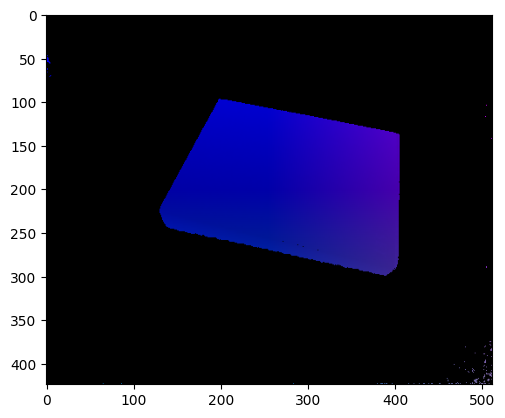

In [145]:
plt.imshow(PC)

In [146]:
def dist(x, y, z, a, b, c, d):
    nominator = abs(a*x + b*y + c*z -d)
    denominator = math.sqrt(a**2 + b**2 + c**2)
    return nominator/denominator

In [149]:
d_floor

np.float64(0.18633546020984892)

In [150]:
d_box

np.float64(nan)

In [ ]:
contours, _ = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest = max(contours, key=cv2.contourArea)

# Finding the extreme points (edges) of the box
top = tuple(largest[largest[:, :, 1].argmin()][0])
left = tuple(largest[largest[:, :, 0].argmin()][0])
bottom = tuple(largest[largest[:, :, 1].argmax()][0])
right = tuple(largest[largest[:, :, 0].argmax()][0])

# Adding annotations to the image
output_image = cv2.cvtColor(filtered_mask, cv2.COLOR_GRAY2BGR)

cv2.line(output_image, left, bottom, (72,209,204) , 2) 
cv2.line(output_image, bottom, right, (72,209,204) , 2) 
cv2.line(output_image, right, top, (72,209,204) , 2) 
cv2.line(output_image, top, left, (72,209,204) , 2) 

cv2.putText(output_image, "left", left, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,182,193),1)
cv2.putText(output_image, "right", right, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,182,193),1)
cv2.putText(output_image, "top", top, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,182,193),1)
cv2.putText(output_image, "bottom", bottom, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,182,193),1)

show_image(output_image, "Output Image")